In [88]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

# Dataset 1 V1 (80:20)
# EN 98.90%
# CNN 93%
# Eff 95%

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [4]:
labels = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [5]:
labels_1=['MD', 'MOD', 'ND', 'VMD']

In [6]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 448/448 [00:03<00:00, 115.68it/s]


In [7]:
Xtrain.shape

(6400, 150, 150, 3)

In [8]:
Ytrain.shape

(6400,)

In [9]:
Xtrain,Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [10]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.2, random_state=42)

In [11]:
xtrain.shape

(5120, 150, 150, 3)

In [ ]:
Ytrain.shape

In [ ]:
xtest.shape

In [ ]:
ytest.shape

## Converting labels into One hot encoder

In [12]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [13]:
ytrain.shape

(5120, 4)

In [ ]:
ytest.shape

# DENSENET MODEL

In [14]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

29084464/29084464 [==============================] - 0s 0us/step


In [15]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [54]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [17]:
#history=model.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
history = model.load_weights('/kaggle/input/h5-files-d2-80-20/DENSE_D2_80_20.h5')
#history=model.fit(xtrain,ytrain,epochs=20,validation_data=(xtest,ytest))

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/DENSE_D2_80_20.csv', index=False)

# Save the model itself
model.save('/kaggle/working/DENSE_D2_80_20.h5')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet-121 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('dense_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet-121 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('dense_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('DenseNet-121 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('DenseNet-121_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('DenseNet-121 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('DenseNet-121_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [41]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

40/40 [==============================] - 2s 41ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.98      0.97       187
ModerateDemented       1.00      0.95      0.97        19
     NonDemented       0.98      0.99      0.98       632
VeryMildDemented       0.99      0.97      0.98       442

        accuracy                           0.98      1280
       macro avg       0.98      0.97      0.98      1280
    weighted avg       0.98      0.98      0.98      1280



In [42]:
accuracy_score(actual_label, pred)

0.98125

In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label, pred, average='weighted')

print("Precision Score:", precision)




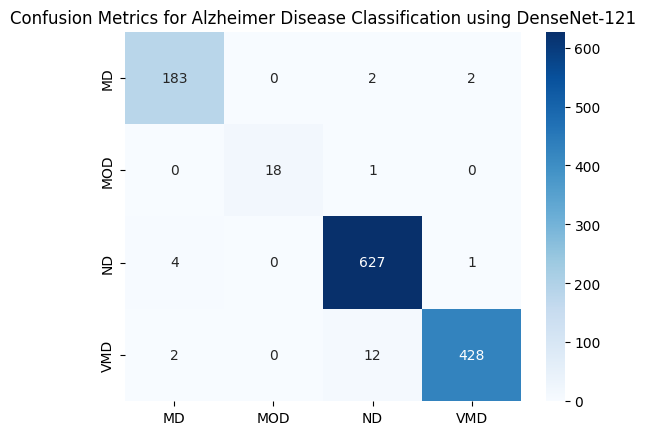

In [20]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using DenseNet-121")
plt.savefig('densenet_confusion_97%.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

## CNN MODEL

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [23]:
#Create the model
cnn=Sequential()
#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(image_size, image_size, 3)))
#add a Max Pooling layer
cnn.add(MaxPooling2D())
#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Flatten before adding fully connected layer
cnn.add(Flatten())
#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))
#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))
#Add final output layer with 4 output nodes using softmax
cnn.add(Dense(4,activation='softmax'))

In [25]:
cnn.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [26]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 32)        4128      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 18, 18, 32)       

In [27]:
history1=cnn.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
#history1 = cnn.load_weights('/kaggle/input/h-5-files/CNN_90_10.h5')

Epoch 1/50
160/160 [==============================] - 11s 28ms/step - loss: 2.4627 - accuracy: 0.7950 - precision: 0.6188 - recall: 0.4684 - auc: 0.8163 - val_loss: 0.8020 - val_accuracy: 0.8240 - val_precision: 0.6928 - val_recall: 0.5320 - val_auc: 0.8822
Epoch 2/50
160/160 [==============================] - 4s 24ms/step - loss: 0.7095 - accuracy: 0.8475 - precision: 0.7318 - recall: 0.6154 - auc: 0.9089 - val_loss: 0.7264 - val_accuracy: 0.8527 - val_precision: 0.7206 - val_recall: 0.6711 - val_auc: 0.9106
Epoch 3/50
160/160 [==============================] - 4s 24ms/step - loss: 0.5938 - accuracy: 0.8739 - precision: 0.7729 - recall: 0.7018 - auc: 0.9356 - val_loss: 0.6068 - val_accuracy: 0.8738 - val_precision: 0.7673 - val_recall: 0.7109 - val_auc: 0.9330
Epoch 4/50
160/160 [==============================] - 4s 24ms/step - loss: 0.4579 - accuracy: 0.9065 - precision: 0.8302 - recall: 0.7869 - auc: 0.9615 - val_loss: 0.4798 - val_accuracy: 0.9039 - val_precision: 0.8214 - val_reca

In [28]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history1.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/CNN__D2_80_20.csv', index=False)

# Save the model itself
cnn.save('/kaggle/working/CNN_D2_80_20.h5')

In [29]:
pred1 = cnn.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels))

40/40 [==============================] - 0s 7ms/step
                  precision    recall  f1-score   support

    MildDemented       0.94      0.92      0.93       187
ModerateDemented       0.94      0.89      0.92        19
     NonDemented       0.97      0.97      0.97       632
VeryMildDemented       0.94      0.96      0.95       442

        accuracy                           0.96      1280
       macro avg       0.95      0.94      0.94      1280
    weighted avg       0.96      0.96      0.96      1280



In [30]:
accuracy_score(actual_label1, pred1)

0.9578125

In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label1, pred1, average='weighted')

print("Precision Score:", precision)

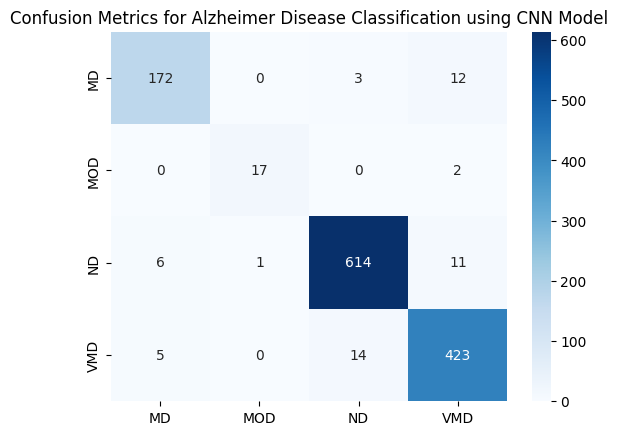

In [31]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

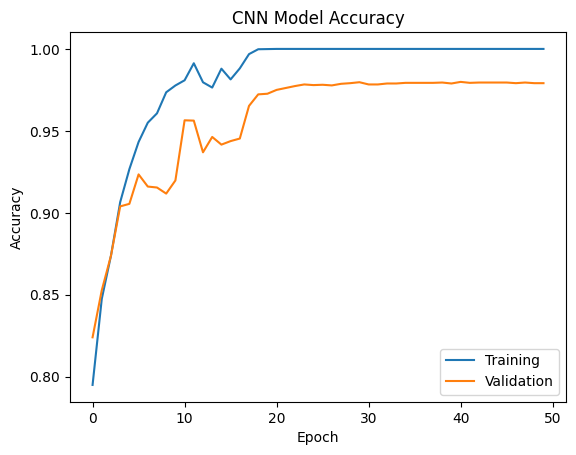

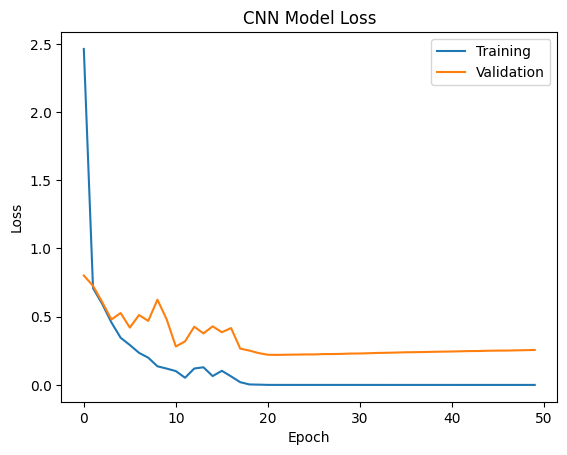

In [32]:
# Plot the training and validation accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

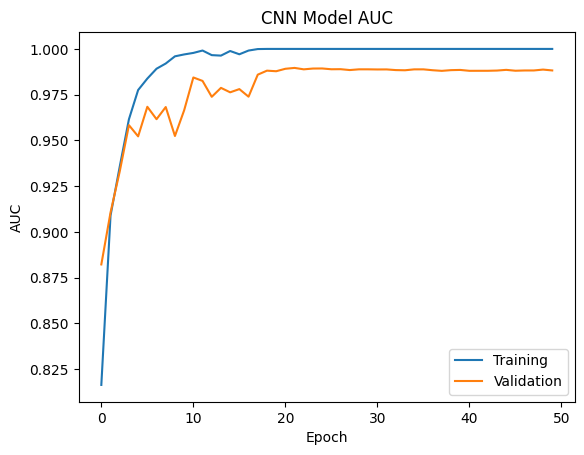

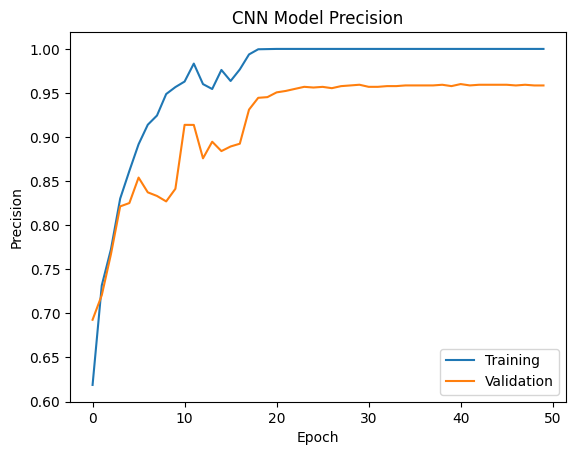

In [33]:
# Plot the training and validation auc
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Efficient NetB7 Model

In [34]:
from tensorflow.keras.applications import EfficientNetB7

In [35]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 1s 0us/step


In [36]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [55]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [38]:
history2=model2.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fe94d029120>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



In [39]:
history2 = model2.load_weights('/kaggle/input/h5-d2-80-20-2/EFF_D2_90_10.h5')

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history2.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/EFF_D2_90_10.csv', index=False)

# Save the model itself
model2.save('/kaggle/working/EFF_D2_90_10.h5')

In [ ]:
history2 = model2.load_weights('/kaggle/input/h-files/efficientb7.h5')


In [40]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2,target_names = labels))

40/40 [==============================] - 13s 172ms/step
                  precision    recall  f1-score   support

    MildDemented       0.90      0.97      0.93       187
ModerateDemented       1.00      0.89      0.94        19
     NonDemented       0.99      0.97      0.98       632
VeryMildDemented       0.97      0.97      0.97       442

        accuracy                           0.97      1280
       macro avg       0.96      0.95      0.95      1280
    weighted avg       0.97      0.97      0.97      1280



In [43]:
accuracy_score(actual_label2, pred2)

0.965625

In [ ]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Efficient NetB7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Efficient NetB7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('Efficient NetB7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history2.history['precision'])
plt.plot(history2.history['val_precision'])
plt.title('Efficient NetB7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_precision.png', dpi=300) # Save plot as PNG
plt.show()

# VGG19 MODEL

In [ ]:
image_size = 150

In [44]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(4,activation="softmax"))
#model.summary()

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model3.summary()

## Compile VGG19 Model

In [45]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
#history3=model3.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))


In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history3.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/VGG_D2_19.csv', index=False)

# Save the model itself
model3.save('/kaggle/working/VGG_D2_19.h5')

In [ ]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels))

In [ ]:
accuracy_score(actual_label3, pred3)

In [ ]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG-19")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('VGG-19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('VGG-19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('VGG-19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('VGG-19_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
plt.plot(history3.history['auc'])
plt.plot(history3.history['val_auc'])
plt.title('VGG-19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('VGG-19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3.history['precision'])
plt.plot(history3.history['val_precision'])
plt.title('VGG-19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('VGG-19_precision.png', dpi=300) # Save plot as PNG
plt.show()

ResNet 50


In [46]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [47]:
rn = ResNet50(input_shape=(150,150,3), weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [48]:
for layer in rn.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model4 = Sequential()
model4.add(rn)
model4.add(Flatten())
model4.add(Dense(4,activation="softmax"))

In [56]:
model4.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [50]:

#history4=model4.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
history4=model4.load_weights('/kaggle/input/h5-d2-80-20-2/RES_D2_80_20.h5')

In [ ]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history4.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/RES_90.csv', index=False)

# Save the model itself
model4.save('/kaggle/working/RES_D2_80_20.h5')

In [51]:
pred4 = model4.predict(xtest)
pred4 = np.argmax(pred4, axis=1)
actual_label4 = np.argmax(ytest, axis=1)
print(classification_report(actual_label4, pred4 , target_names = labels))

40/40 [==============================] - 4s 45ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.84      0.90       187
ModerateDemented       1.00      0.89      0.94        19
     NonDemented       0.93      0.97      0.95       632
VeryMildDemented       0.92      0.93      0.92       442

        accuracy                           0.94      1280
       macro avg       0.96      0.91      0.93      1280
    weighted avg       0.94      0.94      0.93      1280



In [52]:
accuracy_score(actual_label4, pred4)

0.93515625

In [ ]:
Cm1=confusion_matrix(actual_label4,pred4)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using ResNet-50")
plt.savefig('res_confusion.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
# Plot the training and validation accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('ResNet-50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('ResNet-50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_loss.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('ResNet-50 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history4.history['precision'])
plt.plot(history4.history['val_precision'])
plt.title('ResNet-50 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
accuracy_score(actual_label4, pred4)

In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label4, pred4, average='weighted')

print("Precision Score:", precision)

In [57]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = cnn.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
#scores3 = model3.evaluate(xtest, ytest, verbose=1)
scores4 = model4.evaluate(xtest, ytest, verbose=1)


40/40 [==============================] - 3s 49ms/step - loss: 0.2609 - accuracy: 0.9768 - precision: 0.9548 - recall: 0.9523 - auc: 0.9908


## Densenet 

In [81]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [82]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [83]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

Resnet 50


In [84]:
precision4 = scores4[0]
f1_score4 = scores4[1]
recall4 = scores4[2]
accuracy4 = scores4[3]

In [85]:
import pandas as pd

# Creating an empty DataFrame
eval_df = pd.DataFrame(columns=['Model', 'Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [76]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [87]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Efficient Net B7', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Resnet50', 'Precision': precision4, 'F1 Score': f1_score4, 'Recall': recall4, 'Accuracy': accuracy4}, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
eval_df

In [ ]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

## Ensemble Learning

In [70]:
pred = model.predict(xtest)
pred1=cnn.predict(xtest)
pred2 = model2.predict(xtest)
pred4=model4.predict(xtest)
ensemble_preds = np.average([pred ,pred1 ,pred2 ,pred4], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)
print(classification_report(actual_label_final, final_preds,target_names = labels_1))
accuracy_score(actual_label_final, final_preds)

40/40 [==============================] - 3s 48ms/step
              precision    recall  f1-score   support

          MD       0.99      0.98      0.98       187
         MOD       1.00      0.89      0.94        19
          ND       0.99      1.00      0.99       632
         VMD       0.99      0.99      0.99       442

    accuracy                           0.99      1280
   macro avg       0.99      0.97      0.98      1280
weighted avg       0.99      0.99      0.99      1280



0.990625

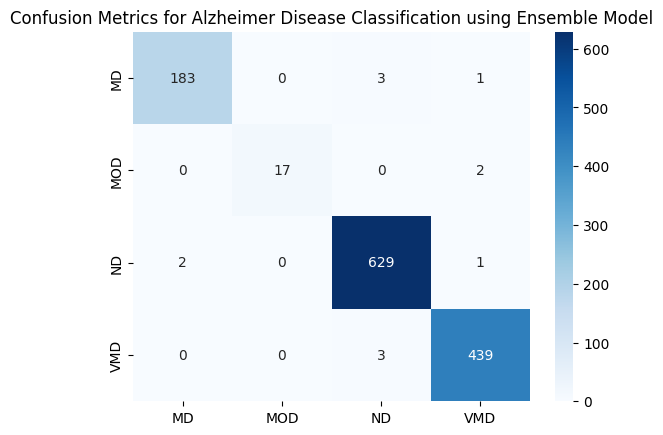

In [71]:
Cm4=confusion_matrix(actual_label_final,final_preds)
ax3=plt.axes()
sns.heatmap(Cm4, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion_98%.png', dpi=300) # Save plot as PNG
plt.show()